In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import (
    store_bin,
    project_dir,
    data_files,
    load_csv,
    load_bin,
    write_xlsx,
    load_txt
)

from pa_lib.data import (
    as_dtype,
    dtFactor,
    desc_col,
    lookup,
    clean_up_categoricals
)

from pa_lib.util import (
    collect,
    value,
    flatten,
    normalize_rows,
    list_items
)

from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data files

In [2]:
with project_dir("MediaFocus"):
    # List files in folder:
    display(data_files("*.feather"))
    
    # Branchen per KW über sie letzten 10 Jahre:
    br_kw     = load_bin("branchen_kw_10y.feather")
    
    # Wie oben, aber unterhalb Branchen noch nach Produktgruppen aufgeteilt:
    br_pg_kw  = load_bin("branchen_pg_kw_10y.feather")
    
    
    br_wbt_kw = load_bin("branchen_wbt_kw.feather")

,size,mtime
name,,
branchen_kw_10y.feather,100.9 KB,31.10.19 15:28:44
branchen_pg_kw_10y.feather,553.2 KB,31.10.19 15:28:44
branchen_wbt_kw.feather,15.2 MB,31.10.19 15:28:44


16:31:57 [INFO] Started loading binary file ...
16:31:57 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_kw_10y.feather
16:31:57 [INFO] ... finished loading binary file in 0.07s (0.05s CPU)
16:31:57 [INFO] Started loading binary file ...
16:31:57 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_pg_kw_10y.feather
16:31:57 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)
16:31:57 [INFO] Started loading binary file ...
16:31:57 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_wbt_kw.feather
16:31:57 [INFO] ... finished loading binary file in 0.01s (0.02s CPU)


In [12]:
print(80*"#"+"\n")
print("br_kw")
display(br_kw.shape)
display(
    br_kw.sample(5)
)


print(80*"#"+"\n")
print("br_pg_kw")
display(br_pg_kw.shape)
display(
    br_pg_kw.sample(5)
)


print(80*"#"+"\n")
print("br_wbt_kw")
display(br_wbt_kw.shape)
display(
    br_wbt_kw.sample(5)
)
print(80*"#")

################################################################################

br_kw


(231, 55)

,Jahr,Branche,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
143,2015,TABAKWAREN,11941,20897,24647,20897,86707,282333,274572,125967,140937,213055,225848,234145,127724,120320,435608,361037,452385,454198,239600,382428,456090,344625,212943,203307,207984,197890,73930,105419,54680,65640,37690,20800,20800,20800,39100,63880,162245,94830,93935,80828,82440,68600,351157,261373,419402,286145,361831,330924,306420,424624,364887,98811,24347
180,2017,MODE + SPORT,2235895,1856302,1742649,2300685,2225990,2496356,2514382,3035933,6225355,5215171,6590278,7354205,9153816,8276969,6642980,4336665,4647754,6520191,5567958,6883155,3510308,3989114,2578119,2386617,2122434,2929525,1807671,1532717,2258068,1897836,1939243,2651658,2919179,3225725,6411875,5132393,8616725,8727174,6570006,6405242,5933154,6295575,6039971,6499219,5532889,7286587,8113214,11648302,9216696,7281437,4989297,3485790,0
57,2011,PHARMA + GESUNDHEIT,2723920,3905523,5055352,4849508,3231131,2685955,2097154,2781932,4779460,2107648,2628657,2716180,3949838,2306503,2075559,2054958,2980381,4054032,3261928,2708567,3305151,3545288,2551665,3020528,2320840,2983568,1336613,1203636,1312777,1280318,873154,1542789,1477258,1839122,3831174,3453283,2573687,3351072,3153888,2326071,2992249,3214748,3954492,6007404,3552472,3093250,3627042,4227772,2501726,2694428,2038052,2485424,0
25,2010,ENERGIE,134009,150655,392680,470801,610698,392398,250863,538917,1736467,782286,786994,705129,681697,490087,861718,971563,787164,563587,607464,530140,664882,693674,328223,516189,310217,381548,465889,392603,503354,382624,434007,707359,403562,501450,896022,983548,793765,985888,1009997,648605,650042,654662,624923,548820,548084,478197,370907,565182,369518,397277,294968,230690,12986
28,2010,"FREIZEIT, GASTRONOMIE, TOURISMUS",4476372,5900599,5029547,4671708,6809244,3647682,3672772,3675138,6569758,4968232,5732707,4265862,5272689,3331850,4851917,5062474,5044993,4509669,4347368,4418544,5643845,5977072,3678604,4244763,5231632,4818472,3102677,2849461,3557647,4147533,2497428,3450830,3887571,3937753,6010098,4050633,4390609,5014058,7162316,4362104,3182211,3311626,3856127,4413803,4421528,4377740,5118538,6322981,4260935,4246465,3354118,1783199,2249779


################################################################################

br_pg_kw


(1309, 56)

,Jahr,Branche,Produktgruppe,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
1203,2019,DETAILHANDEL,WARENHAEUSER,79445,107478,84517,126101,108324,67879,222895,215270,698681,942023,1028777,501332,692508,521312,576378,653333,384202,492006,111154,81861,416328,72653,128566,269687,128385,18018,137482,12578,139711,2177,171010,40513,158346,1849,576381,587248,581352,608980,696295,73945,0,0,0,0,0,0,0,0,0,0,0,0,0
348,2011,VERANSTALTUNGEN,SONSTIGE VERANSTALTUNGEN,207805,136112,146162,183342,218746,501313,493470,347579,277194,187607,146675,116228,229220,259531,140700,307834,370473,440917,237371,359633,343841,388826,314443,228112,255446,315630,175254,45316,118087,125390,256524,280658,332890,489851,625210,320945,350067,431525,221343,269793,207230,342834,435933,330349,289685,353456,229120,298081,171716,230944,110148,114029,0
495,2013,DIGITAL + HAUSHALT,FOTO + VIDEO,230771,266332,359705,203567,202763,34571,99844,69796,285214,43423,130278,89373,270342,288471,51793,54836,111902,207608,74522,101392,312328,1035896,351902,278266,126607,195264,207694,90299,343403,308431,524111,166614,91916,144546,509546,202897,350926,304099,214507,567043,531594,525158,1180052,1204920,355405,569401,873558,1569940,1329749,1296520,459339,684290,0
1282,2019,PHARMA + GESUNDHEIT,FUSS- / BEINPFLEGE,0,0,0,0,0,0,0,0,9620,0,8400,0,10550,9620,15578,0,0,11435,122306,139433,166155,18350,6600,119755,141059,127206,0,0,109801,87172,133805,0,0,0,0,16830,0,0,15578,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1067,2017,VERKEHRSBETRIEBE,LUFTFAHRT,970336,1001058,1067536,1113021,892444,725859,734454,156931,364938,358613,402003,664767,1147973,564417,499262,264964,342769,888305,1131999,1267371,618508,722498,530486,410789,290543,248637,117103,91460,116152,87761,204855,109832,168366,1168092,2032640,1281534,831608,369134,780989,1012439,698039,637215,1722260,2089564,1039292,448365,899093,966569,1007950,798029,616124,674848,0


################################################################################

br_wbt_kw


(35471, 55)

,Branche,Werbungtreibender,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
21763,"FREIZEIT, GASTRONOMIE, TOURISMUS",FLOATING CENTER LUZERN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1980,0,0,0,0,0,0,0,0,0,0,0,0,0
9120,DIENSTLEISTUNG,AYURA SKINCOSMETIC AG,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,75,0,0,0,0,0,0,0,0,0,0,0,0,0,45
1853,"BAUEN, INDUSTRIE, EINRICHTUNG",EGLI GARTENBAU AG,217,217,217,217,217,217,217,217,245,213,213,213,213,213,213,213,213,213,213,213,213,1533,213,213,213,213,213,213,213,213,213,213,213,213,214,217,217,217,217,217,217,217,217,217,217,217,217,217,217,217,217,217,0
8521,DETAILHANDEL,SHOPPINGCENTER GAEUPARK,27763,3419,3419,4495,2929,8749,2929,2929,2929,6754,15544,104643,29240,7549,69930,40655,15498,2929,16184,28153,13892,70221,21190,8117,17673,9287,3809,2929,6563,19489,24014,31530,2929,7762,2930,5276,8396,20662,23729,10438,2260,2260,2260,2260,2260,2260,2260,27822,44970,76449,27849,49523,13423
28392,MODE + SPORT,BADER VERSAND (SCHWEIZ) AG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27500,0,0,46396,0,0,83627,0,0,96035,18400,0,0,0,0,0,0,0,0,0,0,0,0,0,9200,0,47520,0,0,0,0


################################################################################


# Find patterns

In [80]:
len(set(br_kw.loc[:,"Branche"]))

21

In [38]:
kw_columns = list(br_kw.columns)[2:]
br_kw.loc[:,"Brutto"] = br_kw.loc[:,kw_columns].sum(axis=1)

In [62]:
br_kw.loc[:, ["Branche", "Jahr", "Brutto"]].sort_values(["Branche", "Jahr"], ascending=[True, True]).head(20)

,Branche,Jahr,Brutto
0,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,450744542
21,"BAUEN, INDUSTRIE, EINRICHTUNG",2010,521469108
42,"BAUEN, INDUSTRIE, EINRICHTUNG",2011,538074902
63,"BAUEN, INDUSTRIE, EINRICHTUNG",2012,529689714
84,"BAUEN, INDUSTRIE, EINRICHTUNG",2013,569037466
105,"BAUEN, INDUSTRIE, EINRICHTUNG",2014,572272392
126,"BAUEN, INDUSTRIE, EINRICHTUNG",2015,557585200
147,"BAUEN, INDUSTRIE, EINRICHTUNG",2016,523243472
168,"BAUEN, INDUSTRIE, EINRICHTUNG",2017,475980234
189,"BAUEN, INDUSTRIE, EINRICHTUNG",2018,468419626


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [87]:
branchen_liste = list(set(br_kw.loc[:,"Branche"]))
branchen_liste[0:7]

['VERKEHRSBETRIEBE',
 'GETRAENKE',
 'KOSMETIK + KOERPERPFLEGE',
 'FREIZEIT, GASTRONOMIE, TOURISMUS',
 'NAHRUNGSMITTEL',
 'DETAILHANDEL',
 'DIENSTLEISTUNG']

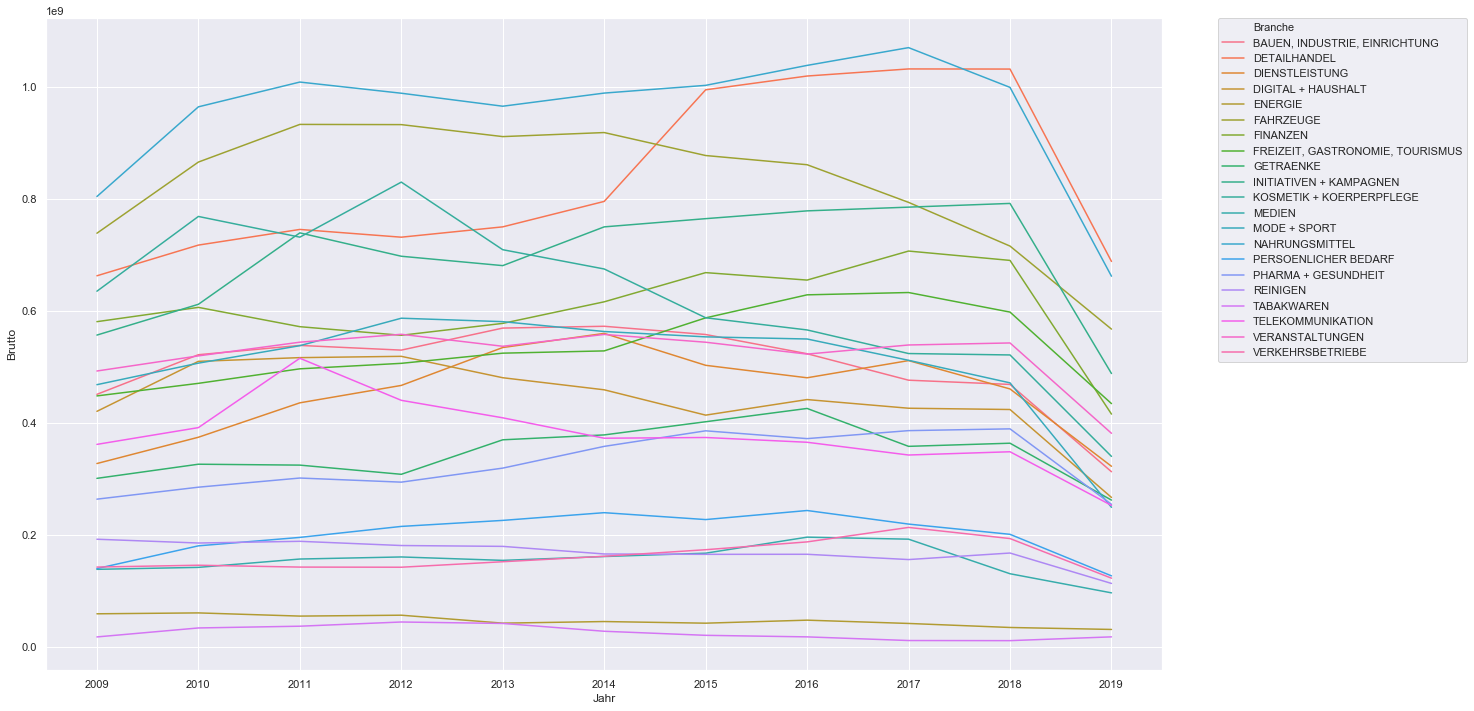

In [61]:
plt.figure(
    figsize=(20, 12)
)

sns.lineplot(
    data=br_kw,
    x="Jahr",
    y="Brutto",
    hue="Branche",
)

# Put the legend out of the figure
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.
)

In [103]:
row_select = (br_kw.loc[:,"Jahr"] == str(2009))
br_kw_2019 = br_kw.loc[row_select,["Branche","Brutto"]].rename(columns={"Brutto": "Brutto_2019"})


container_df = (
    br_kw
        .merge(
            br_kw_2019,
            on = "Branche",
            how= "left"
       )
)

container_df.loc[:,"Growth_Percent"] = (container_df.loc[:,"Brutto"] / container_df.loc[:,"Brutto_2019"] -1)*100

def lineplot_branches(select_branches):
    branch_select = container_df.loc[:,"Branche"].isin(select_branches)
    plt.figure(
        figsize=(20, 10)
    )

    sns.lineplot(
        data=container_df.loc[branch_select,:].pipe(clean_up_categoricals),
        x="Jahr",
        y="Growth_Percent",
        hue="Branche",
        dashes=True,
        markers=True,
    )

    # Put the legend out of the figure
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.
    )
    plt.show()



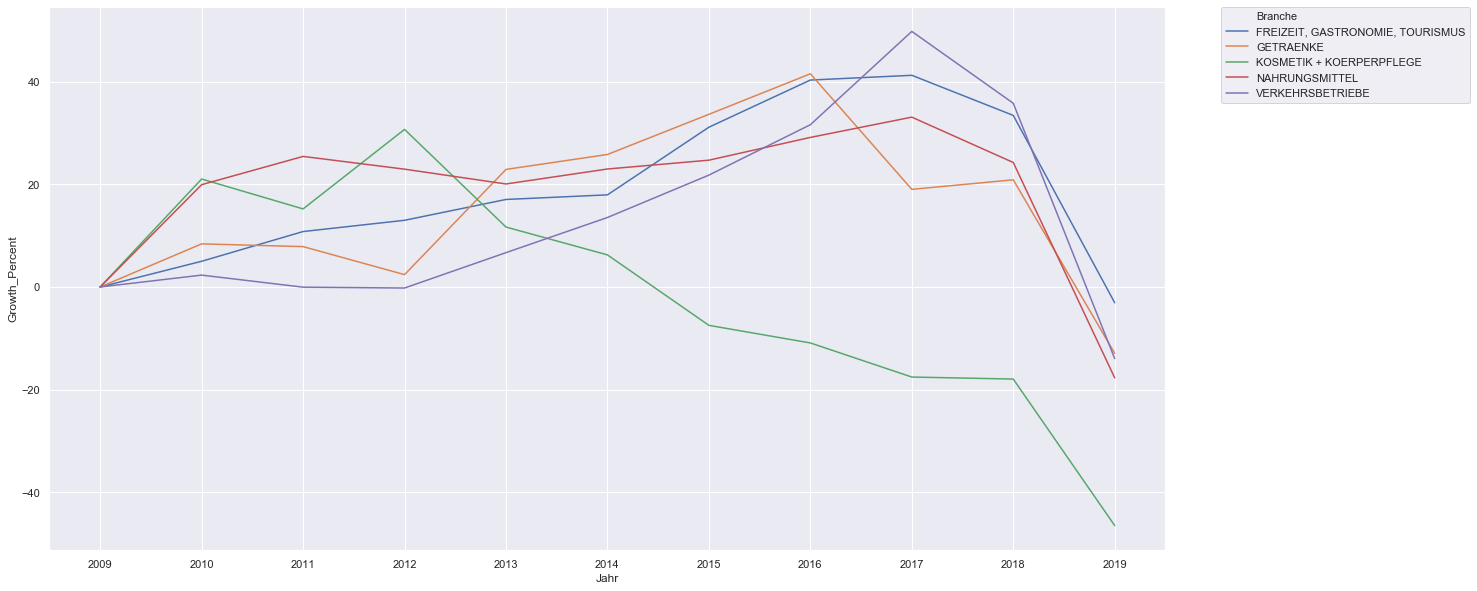

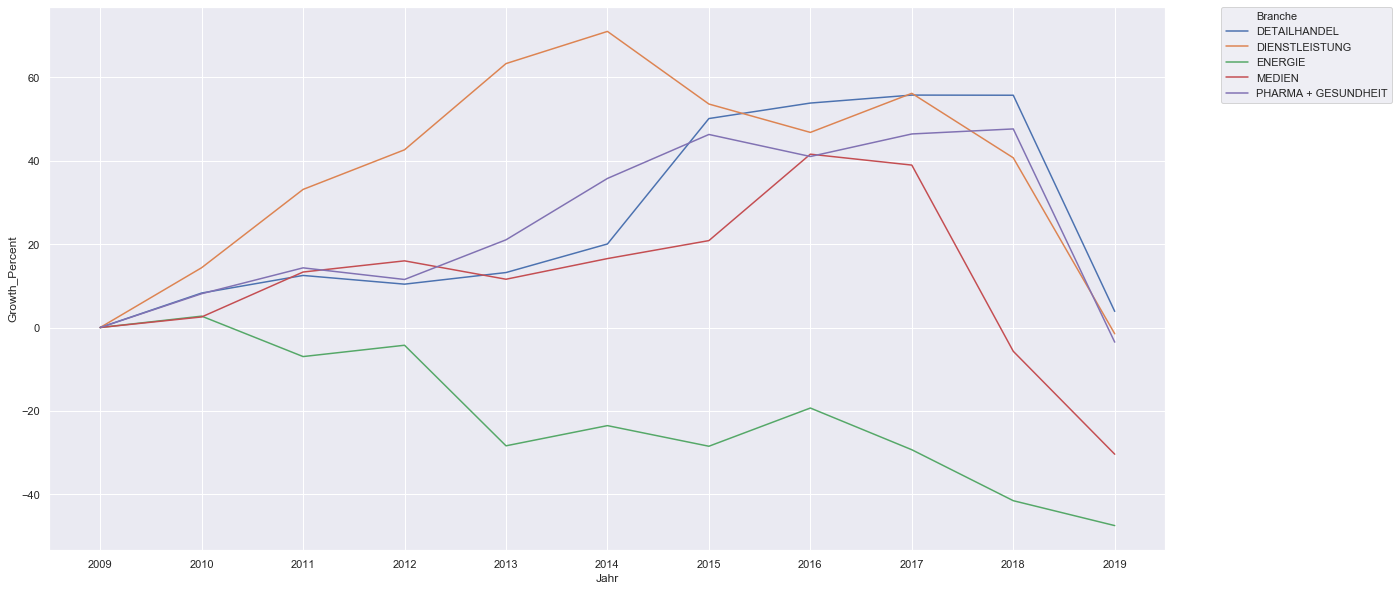

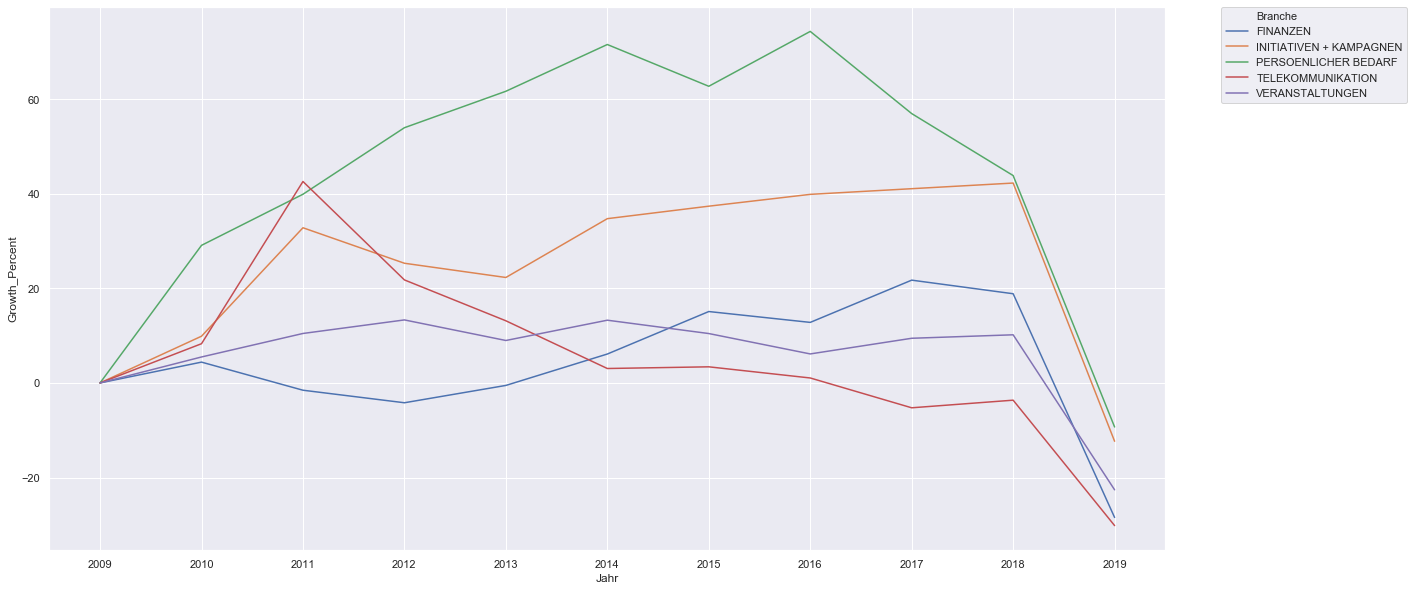

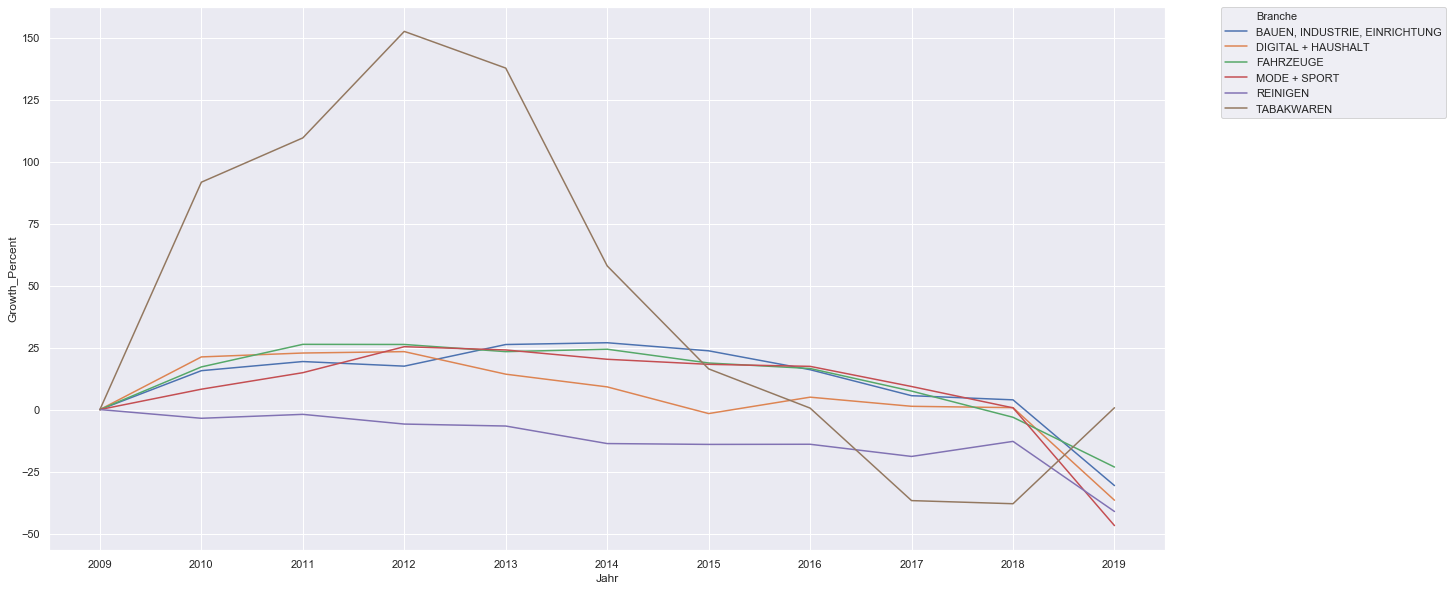

In [106]:
lineplot_branches(select_branches=branchen_liste[0:5])
lineplot_branches(select_branches=branchen_liste[5:10])
lineplot_branches(select_branches=branchen_liste[10:15])
lineplot_branches(select_branches=branchen_liste[15:])


In [121]:
desc_col(br_kw.loc[:,["Jahr","Brutto","Branche"]])

,DTYPE,NULLS,UNIQUE
Jahr,category,0/231,11
Brutto,int64,0/231,231
Branche,category,0/231,21


In [127]:
np.min(br_kw.Brutto)

10838654

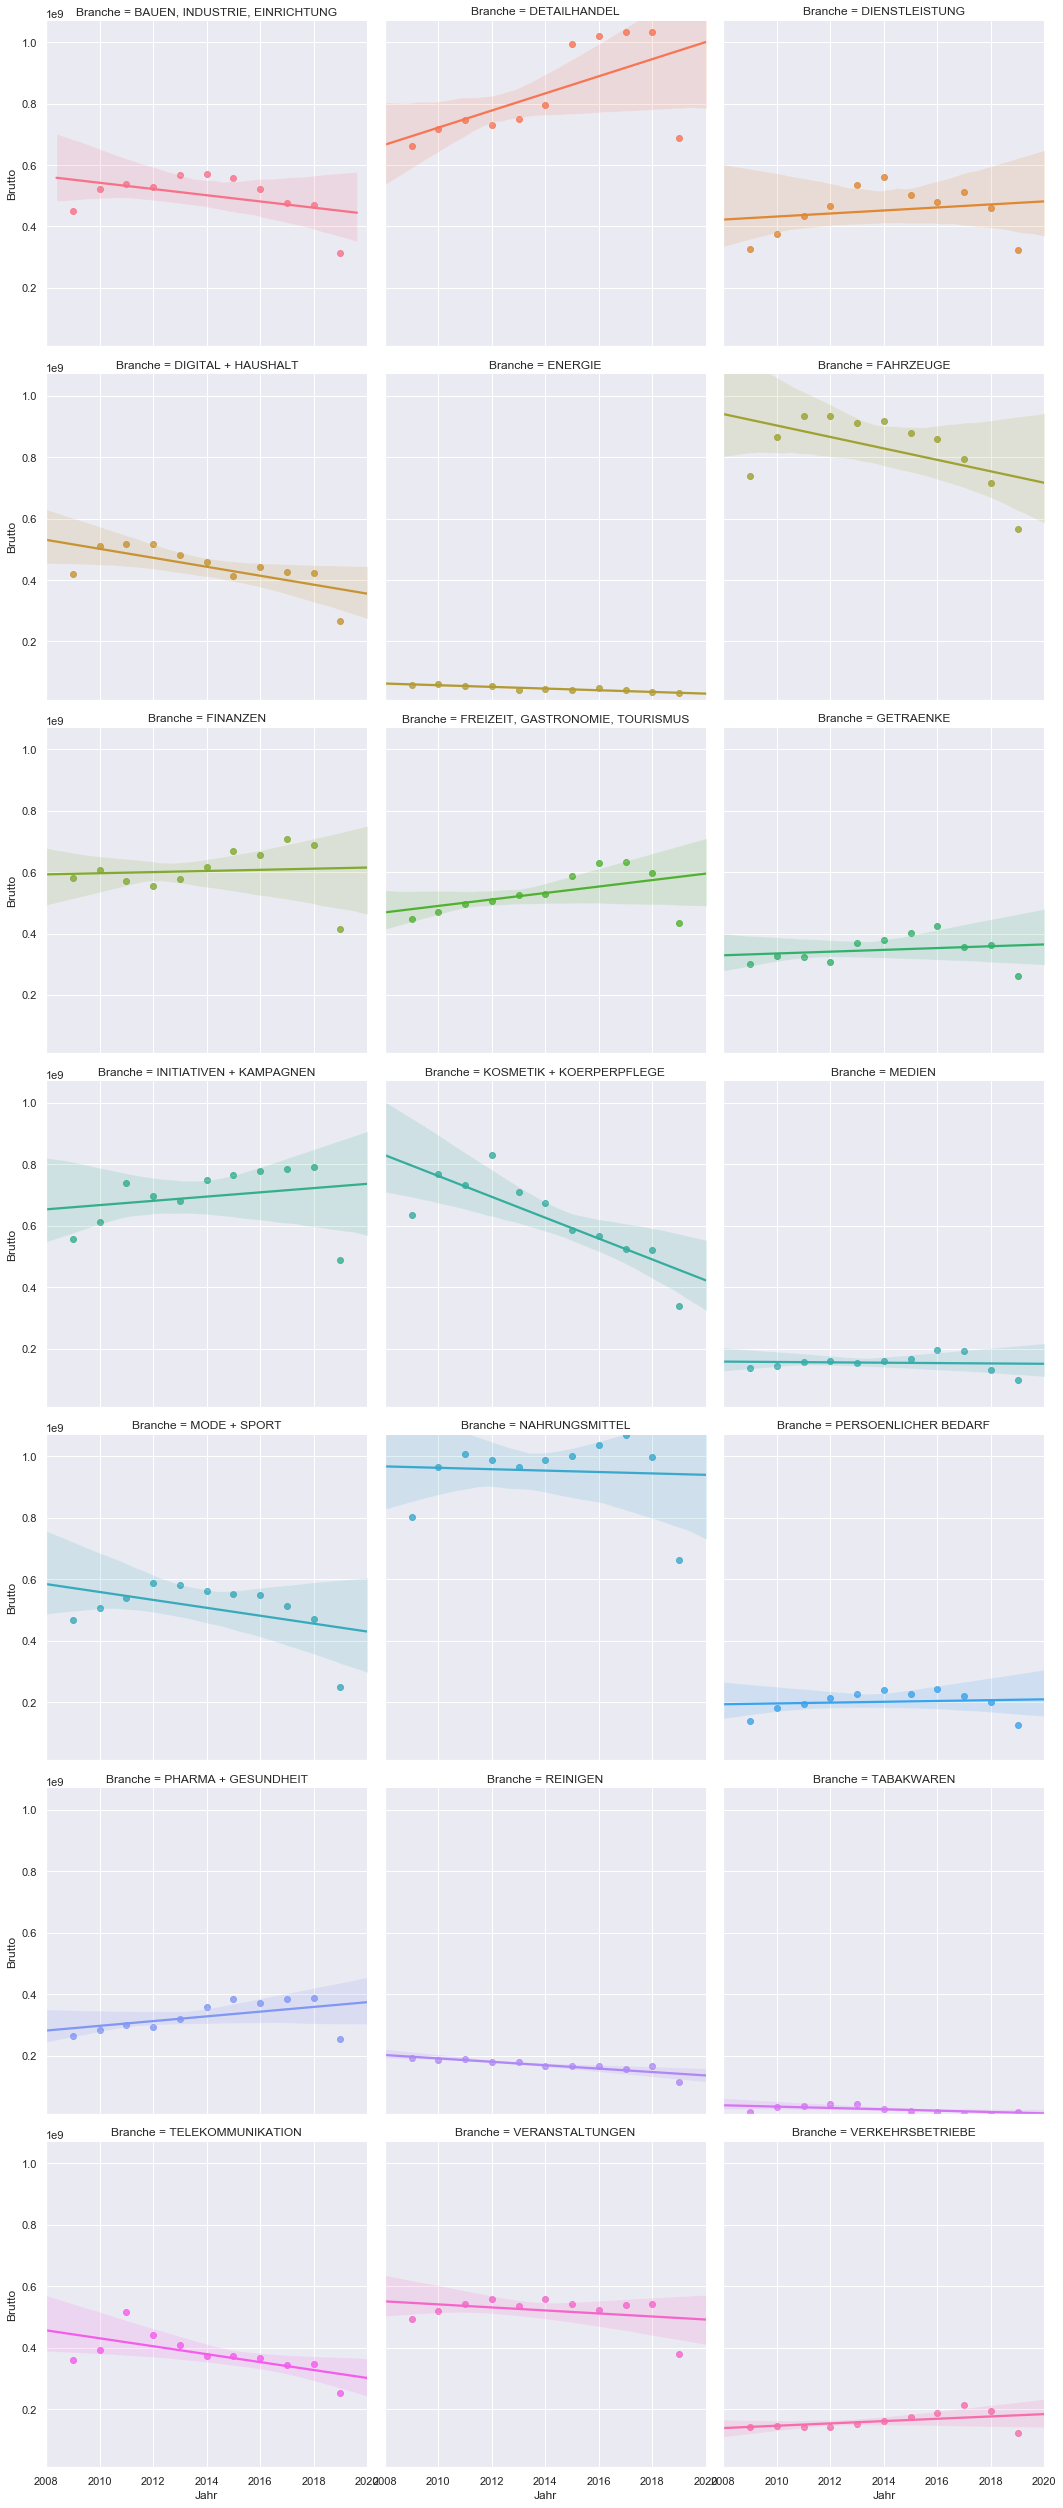

In [132]:
br_kw = br_kw.astype({'Jahr': 'int64'})

#br_kw
g = sns.lmplot(
    x        = "Jahr",
    y        = "Brutto",
    col      = "Branche",
    hue      = "Branche", # kinda useless, but nice to look at!
    data     = br_kw,
    col_wrap = 3,
    height   = 5,
).set(xlim=(2008, 2020),ylim=(np.min(br_kw.Brutto),np.max(br_kw.Brutto)))

# Scribbles

In [107]:
tips = sns.load_dataset("tips")

In [117]:
desc_col(tips)

,DTYPE,NULLS,UNIQUE
total_bill,float64,0/244,229
tip,float64,0/244,123
sex,category,0/244,2
smoker,category,0/244,2
day,category,0/244,4
time,category,0/244,2
size,int64,0/244,6


In [110]:
tips.head(4)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2


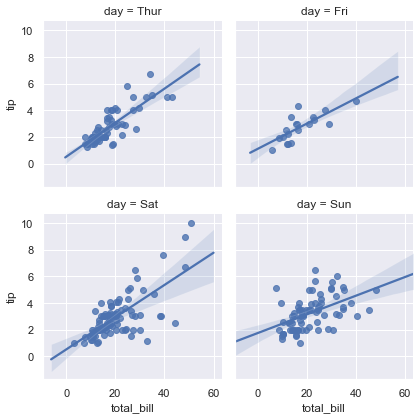

In [113]:
g = sns.lmplot(
    x="total_bill",
    y="tip",
    col="day",
    #hue="day",
    data=tips,
    col_wrap=2,
    height=3
)